# **Building stock selection trading strategies using Learning-to-Rank algorithms**

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm
from sklearn.metrics import ndcg_score
import os
from catboost import CatBoostRanker,Pool
import plotly.express as px
import itertools
from tqdm.notebook import tqdm

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
cwd = os.getcwd()

### Help Functions

In [2]:
def select_stock(data,stock,features_names):
    ## Selects feature of a specific stock from data input
    L = []
    for feature in features_names:
        L.append(data[f"{feature}_{stock}"])
    return L

def select_monthly(data):
    ## Keeps first date of every month in the data
    return data.groupby(data.index.to_period("M")).head(1)

## Data Extraction

The following class allows to download the closing prices of all the components of an index ticker between two dates (date1 and date2) using the Yahoo Finance API

In [3]:

path_to_dw = os.path.join(cwd, "data_spx.pkl")
        
class FETCH_DATA:
    def __init__(self):
        pass

    def get_compo_tickers(self,index_ticker="SPX"):
        ## Gets the tickers of the index
        self.tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()

    def download_compo_cp(self,index_ticker='SPX',date1='1999-1-1',date2='2023-12-1'):
        ## Gets the close prices of every component collected
        self.get_compo_tickers(index_ticker)
        self.data = yf.download(self.tickers,date1,date2, auto_adjust=True)['Close']

try:
    data_source = pd.read_pickle(path_to_dw)
except:
    fetch_data = FETCH_DATA()
    fetch_data.download_compo_cp(index_ticker='SPX',date1='2010-1-1',date2='2023-12-31')
    temp = fetch_data.data
    temp.dropna(axis=1).sort_index().to_pickle(path_to_dw)
    data_source = pd.read_pickle(path_to_dw)

if not isinstance(data_source, pd.DatetimeIndex):
    data_source.index = pd.to_datetime(data_source.index)

We consider the components of the S&P 500 since our start date : 1/1/2010. **We decided to only keep the stocks that were part of the basket of the S&P500 since our start date and have NO missing values**.  
Indeed, some stocks have no available trading close price for several months or consecutive years. 

In [4]:
data_source

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,20.006807,4.562869,6.379697,18.881781,7.950000,31.899059,36.779999,22.572210,21.894424,26.873999,...,52.280952,9.747939,37.906723,13.144472,40.047924,31.608543,19.188128,51.887131,28.350000,10.200066
2010-01-04,20.154913,4.496877,6.478997,19.046156,7.994444,32.337185,37.090000,22.636543,22.006319,26.880278,...,53.053879,10.005535,41.636860,13.057755,40.611744,31.752348,19.253977,52.685947,28.670000,10.597574
2010-01-05,19.935982,5.005957,6.490198,18.892269,7.967778,32.537025,37.700001,22.600805,22.125191,26.735931,...,52.934948,10.217939,44.169182,12.902893,40.770309,31.374886,19.188128,54.353764,28.620001,10.971233
2010-01-06,19.865154,4.798554,6.386964,18.997192,7.933333,32.882927,37.619999,22.557919,22.069246,26.673174,...,53.787167,10.104960,43.589813,12.927672,41.122681,31.581610,19.050957,54.336205,28.400000,11.925252
2010-01-07,19.839392,4.939966,6.375157,19.154564,7.886667,32.852188,36.889999,22.379227,21.838490,26.660631,...,53.628620,10.059768,44.520729,12.871923,40.993488,31.995003,19.045465,55.582699,27.690001,13.260880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,139.334351,14.310000,193.600006,108.505814,73.839996,353.160400,598.750000,197.100006,71.459999,230.970001,...,239.247223,34.360001,90.419998,61.541588,101.910004,35.081612,130.000000,120.319992,269.410004,44.000000
2023-12-26,139.573929,14.110000,193.050003,108.704857,73.510002,352.144104,598.260010,198.869995,72.389999,232.539993,...,238.250732,34.630001,91.000000,61.730000,102.139999,35.400356,130.259995,121.419998,275.500000,44.880001
2023-12-27,139.583923,13.990000,193.149994,109.262161,73.540001,352.532684,596.080017,199.350006,72.169998,231.610001,...,238.460007,34.759998,90.629997,61.540001,101.660004,35.490002,130.839996,121.129997,275.790009,44.509998


## Preprocessing and Features Engineering

We consider the following features : 
- r_1m
- r_3m
- r_6m
- r_12m
- vol_3m
- vol_6m
- vol_12m
- sharpe_3m
- sharpe_6m
- sharpe_12m
- MACD

They are computed to each rebalancing dates as introduced in the Written Report (first date of each month) and for each stock at the corresponding date based on the Close Prices imported earlier.


In [5]:
## Features dataset creation

data = data_source.copy()

features_names = ["r_1m", "r_3m","r_6m","r_12m","vol_3m","vol_6m","vol_12m",
                  "sharpe_3m","sharpe_6m","sharpe_12m", "MACD"]
list_stocks = list(data_source)

data = select_monthly(data)
data = data.reset_index()
list_dates = list(data['Date'])

index_tuples = []
for x in list_dates:
    for y in list_stocks:
        index_tuples.append((x,y))

index = pd.MultiIndex.from_tuples(index_tuples,names=['Dates', 'Stock'])
data_features = pd.DataFrame(index=index,columns=features_names+['Score','Rank'])
data_features = data_features.reset_index()

data = data_source.copy()
df_returns = data.pct_change()

for stock in list_stocks:
    data[f"r_1m_{stock}"] = data[stock]/data[stock].shift(21) - 1
    data[f"r_3m_{stock}"] = data[stock]/data[stock].shift(60) - 1
    data[f"r_6m_{stock}"] = data[stock]/data[stock].shift(120) - 1
    data[f"r_12m_{stock}"] = data[stock]/data[stock].shift(252) - 1
    data[f"vol_3m_{stock}"] = df_returns[stock].rolling(window=60).std() \
    * np.sqrt(60)
    data[f"vol_6m_{stock}"] = df_returns[stock].rolling(window=120).std() \
    * np.sqrt(120)
    data[f"vol_12m_{stock}"] = df_returns[stock].rolling(window=252).std() \
    * np.sqrt(252)
    data[f"sharpe_3m_{stock}"] = data[f"r_3m_{stock}"] / data[f"vol_3m_{stock}"]
    data[f"sharpe_6m_{stock}"] = data[f"r_6m_{stock}"] / data[f"vol_6m_{stock}"]
    data[f"sharpe_12m_{stock}"] = data[f"r_12m_{stock}"] / data[f"vol_12m_{stock}"]
    # Calculate MACD (the difference between 12-period EMA and 26-period EMA)
    data[f'MACD_{stock}'] = data[stock].ewm(span=12, adjust=False).mean() - \
    data[stock].ewm(span=26, adjust=False).mean()

data = select_monthly(data)

for stock in list_stocks:
    custom_features = [feature+f'_{stock}' for feature in features_names]
    selected_rows = list(data_features[data_features['Stock']==stock].index)
    selected_data = data.loc[:,custom_features].values
    data_features.loc[selected_rows,features_names] = selected_data

data_features = data_features.dropna(subset=features_names)

data_features

,Dates,Stock,r_1m,r_3m,r_6m,r_12m,vol_3m,vol_6m,vol_12m,sharpe_3m,sharpe_6m,sharpe_12m,MACD,Score,Rank
5668,2011-01-03,A,0.140523,0.261446,0.459742,0.33802,0.105288,0.210153,0.306933,2.483154,2.187652,1.101281,0.905858,NaN,NaN
5669,2011-01-03,AAL,-0.041404,0.152598,0.147629,1.232705,0.212017,0.315644,0.605765,0.719743,0.467709,2.034955,-0.176581,NaN,NaN
5670,2011-01-03,AAPL,0.035895,0.139514,0.30404,0.539975,0.092895,0.141461,0.267975,1.501834,2.149283,2.015023,0.100237,NaN,NaN
5671,2011-01-03,ABT,0.00441,-0.082989,0.007658,-0.092314,0.059211,0.089289,0.143006,-1.401579,0.085771,-0.645523,-0.061163,NaN,NaN
5672,2011-01-03,ACGL,-0.034057,0.067431,0.134487,0.229882,0.060224,0.10277,0.159518,1.119669,1.308619,1.441101,-0.027017,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73679,2023-12-01,XRAY,0.055447,-0.096124,-0.152451,0.09239,0.156726,0.184615,0.299638,-0.613326,-0.825776,0.30834,0.273597,NaN,NaN
73680,2023-12-01,YUM,0.054677,0.005836,-0.045297,0.008284,0.08479,0.107847,0.159776,0.068829,-0.420014,0.051847,1.128293,NaN,NaN
73681,2023-12-01,ZBH,0.122775,-0.018951,-0.126354,-0.01021,0.124066,0.165429,0.209984,-0.152751,-0.763793,-0.048623,2.113589,NaN,NaN
73682,2023-12-01,ZBRA,0.218344,-0.087118,-0.138469,-0.107518,0.181097,0.290293,0.401734,-0.481056,-0.476998,-0.267635,6.109607,NaN,NaN


A crucial part for the relevance of the strategy is the definition of a score or ranking system that matches our objective for stock selection.  
Since we have a monthly rebalancing frequency, we chose to build our score on the return 1 month.  
Hence, $Score_{m}^{i} = r_{1month, m+1}^{i}$ , with $r_{1month}$ the return 1-month, i the index of the stock, and m the current month.  
The rank is then deduced by simply sorting the scores obtained for each monthly rebalacing date. With this choice of metric, if AAPL is the best performing stock in February, then its rank in January will be 1 in the training set.

In [6]:
## Score Calculation

list_dates_features = list(set(list(data_features['Dates'])))
list_dates_features.sort()
list_dates_features_index = [i for i in range(len(list_dates_features)-1)]

for i in list_dates_features_index:
    date = list_dates_features[i]
    date1 = list_dates_features[i+1]
    dates_index = list(data_features[data_features['Dates']==date].index)
    dates_index1 = list(data_features[data_features['Dates']==date1].index)
    subset = data_features.loc[dates_index,:].drop(['Score','Rank'],axis=1)
    subset1 = data_features.loc[dates_index1,:]

    subset1 = subset1.sort_values(by='r_1m', ascending=False)
    score_series = subset1.loc[:,'r_1m']
    rank_series = [i for i in range(1,len(subset1)+1)]
    subset1.loc[subset1.index,"Score"] = score_series
    subset1.loc[subset1.index,"Rank"] = rank_series
    subset['index'] = subset.index
    subset = subset.merge(subset1[['Stock','Score','Rank']],how='left',on='Stock')
    subset = subset.set_index('index')
    data_features.loc[dates_index,'Score'] = subset.loc[dates_index,"Score"]
    data_features.loc[dates_index,'Rank'] = subset.loc[dates_index,"Rank"]

list_last_values = data_features[data_features['Dates']==list_dates_features[-1]].index
data_features = data_features.drop(list_last_values,axis=0)

data_features

,Dates,Stock,r_1m,r_3m,r_6m,r_12m,vol_3m,vol_6m,vol_12m,sharpe_3m,sharpe_6m,sharpe_12m,MACD,Score,Rank
5668,2011-01-03,A,0.140523,0.261446,0.459742,0.33802,0.105288,0.210153,0.306933,2.483154,2.187652,1.101281,0.905858,0.014966,286
5669,2011-01-03,AAL,-0.041404,0.152598,0.147629,1.232705,0.212017,0.315644,0.605765,0.719743,0.467709,2.034955,-0.176581,-0.00999,354
5670,2011-01-03,AAPL,0.035895,0.139514,0.30404,0.539975,0.092895,0.141461,0.267975,1.501834,2.149283,2.015023,0.100237,0.069662,127
5671,2011-01-03,ABT,0.00441,-0.082989,0.007658,-0.092314,0.059211,0.089289,0.143006,-1.401579,0.085771,-0.645523,-0.061163,-0.047175,405
5672,2011-01-03,ACGL,-0.034057,0.067431,0.134487,0.229882,0.060224,0.10277,0.159518,1.119669,1.308619,1.441101,-0.027017,0.013174,293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73243,2023-11-01,XRAY,-0.077475,-0.213634,-0.241839,0.016196,0.112216,0.161693,0.319062,-1.903776,-1.495667,0.050762,-0.932668,0.055447,319
73244,2023-11-01,YUM,-0.013741,-0.091484,-0.108512,0.044941,0.078199,0.113279,0.160537,-1.169896,-0.95792,0.279941,-1.015093,0.054677,324
73245,2023-11-01,ZBH,-0.047589,-0.15667,-0.228376,-0.065947,0.119549,0.15581,0.220735,-1.310513,-1.465737,-0.298759,-2.692812,0.122775,164
73246,2023-11-01,ZBRA,-0.140407,-0.219528,-0.253656,-0.300932,0.156735,0.285833,0.446588,-1.400633,-0.887428,-0.673847,-8.713233,0.218344,40


In [7]:
## Check Score and Rank Computation (Score(t) vs Rank(t)) : OK

data_features[data_features['Dates']==datetime(2011,1,3)].sort_values('Score',ascending=False)

,Dates,Stock,r_1m,r_3m,r_6m,r_12m,vol_3m,vol_6m,vol_12m,sharpe_3m,sharpe_6m,sharpe_12m,MACD,Score,Rank
5962,2011-01-03,NVDA,0.100139,0.478505,0.43427,-0.144402,0.148282,0.280799,0.431383,3.227003,1.546553,-0.334742,0.105617,0.588961,1
5948,2011-01-03,MU,0.046776,0.164557,-0.053714,-0.236867,0.201902,0.321652,0.510847,0.81503,-0.166995,-0.463674,0.061126,0.34788,2
5879,2011-01-03,ISRG,0.002123,-0.06324,-0.2036,-0.128801,0.15287,0.226602,0.342637,-0.413685,-0.898491,-0.375912,-0.070167,0.29032,3
6095,2011-01-03,WY,0.126568,0.243437,0.349432,0.217716,0.121233,0.202918,0.32646,2.008011,1.722036,0.6669,0.326507,0.262018,4
5940,2011-01-03,MRO,0.072774,0.086675,0.172767,0.208101,0.101372,0.149715,0.243425,0.855013,1.153973,0.854887,0.350917,0.258439,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,2011-01-03,RMD,0.047249,0.070621,0.048346,0.326767,0.09906,0.156571,0.270222,0.712909,0.308782,1.209255,0.477871,-0.111721,432
5873,2011-01-03,INCY,0.040302,0.000606,0.33441,0.738947,0.154813,0.238627,0.458213,0.003913,1.401392,1.612674,0.288913,-0.121377,433
6032,2011-01-03,STZ,0.014078,0.158092,0.320098,0.340571,0.110369,0.144457,0.246277,1.432396,2.215867,1.382876,0.308271,-0.122799,434
5683,2011-01-03,AIG,0.353778,0.434396,0.546763,0.942121,0.216714,0.283242,0.548494,2.004471,1.930371,1.717652,2.483599,-0.140906,435


In [8]:
## Check Score and Rank Computation (r_1m (t+1) vs Score(t)) : OK

data_features[data_features['Dates']==datetime(2011,2,1)].sort_values('r_1m',ascending=False)

,Dates,Stock,r_1m,r_3m,r_6m,r_12m,vol_3m,vol_6m,vol_12m,sharpe_3m,sharpe_6m,sharpe_12m,MACD,Score,Rank
6398,2011-02-01,NVDA,0.588961,0.973387,1.75563,0.461768,0.277366,0.334769,0.486016,3.509398,5.244311,0.95011,0.485353,-0.088805,421
6384,2011-02-01,MU,0.34788,0.26285,0.511888,0.15615,0.196612,0.3129,0.498594,1.336897,1.63595,0.31318,0.602456,0.056895,120
6315,2011-02-01,ISRG,0.29032,0.205874,0.049148,-0.008969,0.186953,0.257484,0.351706,1.101207,0.190879,-0.025502,1.913427,-0.024761,372
6531,2011-02-01,WY,0.262018,0.405294,0.464732,0.533487,0.128424,0.185851,0.325735,3.155906,2.500563,1.637797,0.71238,0.036931,175
6376,2011-02-01,MRO,0.258439,0.387758,0.422824,0.556319,0.113411,0.163839,0.253913,3.419056,2.580722,2.190979,1.097673,0.139956,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6444,2011-02-01,RMD,-0.111721,-0.059021,-0.028264,0.178702,0.121449,0.162136,0.274246,-0.485973,-0.174325,0.651611,-0.598042,0.012548,265
6309,2011-02-01,INCY,-0.121377,-0.097954,0.108994,0.331199,0.16546,0.237778,0.439017,-0.592009,0.458384,0.754409,-0.36204,-0.077186,415
6468,2011-02-01,STZ,-0.122799,-0.026065,0.149704,0.185479,0.130948,0.163675,0.257362,-0.199047,0.914644,0.720695,-0.416232,0.036573,180
6119,2011-02-01,AIG,-0.140906,0.106414,0.308166,1.065122,0.251853,0.292434,0.555084,0.422524,1.053797,1.918846,-0.749824,-0.088425,420


## Models Implementation : first approach

In [9]:
split_date = datetime(2018,12,1)

#### Naive Ranking

We implemented a naive approach that consists solely in taking the previous rank, in order to have a benchmark to be be compared with.

In [10]:
naive_df = pd.concat([data_features,
                      data_features[['Dates', 'Stock', 'Rank']]\
                                   .sort_values(['Dates', 'Stock']).groupby(['Stock'])[['Rank']]\
                                   .apply(lambda x: x.shift(1)).reset_index(level=0, drop=True)\
                                   .rename(columns={'Rank' : 'pred_rank'})
                     ], axis=1).dropna().query('Dates >= @split_date')

naive_df

,Dates,Stock,r_1m,r_3m,r_6m,r_12m,vol_3m,vol_6m,vol_12m,sharpe_3m,sharpe_6m,sharpe_12m,MACD,Score,Rank,pred_rank
47088,2018-12-03,A,0.144894,0.110208,0.132037,0.09685,0.152792,0.176031,0.260041,0.721294,0.750077,0.372443,1.680356,-0.079888,202,8
47089,2018-12-03,AAL,0.093193,0.034594,-0.071221,-0.182995,0.22394,0.275996,0.362878,0.154478,-0.258051,-0.504287,0.998742,-0.154607,393,48
47090,2018-12-03,AAPL,-0.1654,-0.16193,-0.024041,0.096725,0.176879,0.201436,0.264882,-0.915488,-0.119349,0.365162,-2.087835,-0.120468,331,429
47091,2018-12-03,ABT,0.058731,0.126346,0.196082,0.351039,0.118958,0.138461,0.207962,1.062108,1.416148,1.687991,0.784997,-0.051324,104,148
47092,2018-12-03,ACGL,-0.010457,-0.062417,0.031738,-0.102151,0.094493,0.115787,0.187433,-0.660553,0.27411,-0.544997,0.070084,-0.077167,194,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73243,2023-11-01,XRAY,-0.077475,-0.213634,-0.241839,0.016196,0.112216,0.161693,0.319062,-1.903776,-1.495667,0.050762,-0.932668,0.055447,319,372
73244,2023-11-01,YUM,-0.013741,-0.091484,-0.108512,0.044941,0.078199,0.113279,0.160537,-1.169896,-0.95792,0.279941,-1.015093,0.054677,324,237
73245,2023-11-01,ZBH,-0.047589,-0.15667,-0.228376,-0.065947,0.119549,0.15581,0.220735,-1.310513,-1.465737,-0.298759,-2.692812,0.122775,164,322
73246,2023-11-01,ZBRA,-0.140407,-0.219528,-0.253656,-0.300932,0.156735,0.285833,0.446588,-1.400633,-0.887428,-0.673847,-8.713233,0.218344,40,417


In [11]:
print(ndcg_score([naive_df['Rank'].astype(int)],[naive_df['pred_rank'].astype(int)],k=35))

0.5177752293577982


#### LambdaMART

Since we needed several times to inputs for our LambdaMART, this has been written in a function that follows.

In [12]:
## Test Train Split

train = data_features[data_features['Dates']<split_date]
test = data_features[data_features['Dates']>=split_date]

## Group creation

qids_train = train.groupby("Dates")["Dates"].count().to_numpy()

## Keeping only the features on which we would train our model

X_train = train.drop([
    # 'r_1m',
    "Dates", "Stock", "Score","Rank"], axis = 1)

## Relevance label for train

y_train = train['Rank'].astype(int)

## Creating a numpy array which contains eval_group

qids_test = test.groupby("Dates")["Dates"].count().to_numpy()

# Keeping only the features on which we would validate our model

X_test = test.drop([
    # 'r_1m',
    "Dates", "Stock", "Score",'Rank'], axis = 1)

# Relevance label for test

y_test = test['Rank'].astype(int)

## Switch to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [13]:
# Ranker object

ranker = lightgbm.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 100,
                    importance_type = "gain",
                    metric= ["ndcg"],
                    num_leaves = 10,
                    learning_rate = 0.1,
                    max_depth = -1,
                    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[35])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 41420, number of used features: 11


LGBMRanker(importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           metric=['ndcg'], num_leaves=10, objective='lambdarank')

In [14]:
lambdaM_df = test.copy()
lambdaM_df['pred_value'] = ranker.predict(X_test)
lambdaM_df['pred_rank'] = lambdaM_df.groupby('Dates')['pred_value'].rank(method = 'first',
                                                                       ascending=False, pct=False)

In [15]:
print(ranker.best_score_['training'])
print(ranker.best_score_['valid_1'])

OrderedDict([('ndcg@35', 0.6697235852252333)])
OrderedDict([('ndcg@35', 0.5136550017913387)])


Feature importance analysis [...]

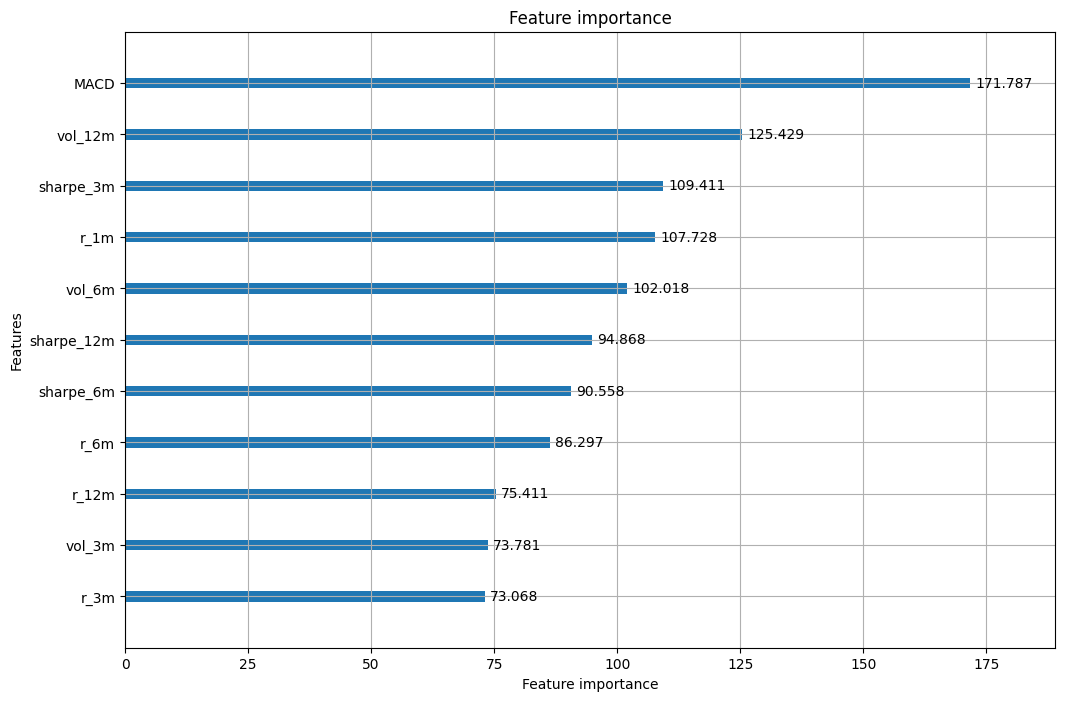

In [16]:
## Feature Importance Analysis for LambdaMART (LightGBM)

lightgbm.plot_importance(ranker, figsize = (12,8))
plt.show()

#### YetiRank

In [17]:
data_features1 = data_features.copy()

data_features1['query_id'] = data_features1.groupby('Dates').ngroup()

## Test Train Split

train = data_features1[data_features1['Dates']<split_date]
test = data_features1[data_features1['Dates']>=split_date]

## Group creation

qids_train = train.groupby("Dates")["Dates"].count().to_numpy()

## Keeping only the features on which we would train our model

X_train = train.drop([
    # 'r_1m',
    "Dates", "Stock", "Score","Rank"], axis = 1)

## Relevance label for train

y_train = train['Rank'].astype(int)

## Creating a numpy array which contains eval_group

qids_test = test.groupby("Dates")["Dates"].count().to_numpy()

# Keeping only the features on which we would validate our model

X_test = test.drop([
    # 'r_1m',
    "Dates", "Stock", "Score","Rank"], axis = 1)

# Relevance label for test

y_test = test['Rank'].astype(int)


## Switch to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

queries_train = train['query_id']
queries_test = test['query_id']

In [18]:
catboost_model = CatBoostRanker(iterations=200, depth=5, learning_rate=0.01, loss_function='YetiRank')
train_pool = Pool(data=X_train, label=y_train, group_id=queries_train)

# Specify the query information for the test set
test_pool = Pool(data=X_test, label=y_test, group_id=queries_test)

catboost_model.fit(train_pool,verbose=200)
catboost_predictions = catboost_model.predict(test_pool)

0:	total: 428ms	remaining: 1m 25s
199:	total: 32.3s	remaining: 0us


In [19]:
yetiR_df = test.copy()
yetiR_df['pred_score'] = catboost_predictions
yetiR_df['pred_rank'] = yetiR_df.groupby('Dates')['pred_score'].rank(method = 'first',
                                                                       ascending=False, pct=False)
yetiR_df['pred_rank'] = yetiR_df['pred_rank'].astype(int)                                                                       

In [20]:
print(ndcg_score([yetiR_df['Rank'].astype(int)],[yetiR_df['pred_rank'].astype(int)],k=35))

0.49862385321100916


## Backtests

To have an idea of the different resulting trading strategies, a good mean is to plot the backtests.

The following cell implements a class to build the trading strategies.

In [21]:
class EquityBasketVolTarget:

    def __init__(self, prices, scores, VT=15/100, grp_size=10):
    ## prices : DataFrame with columns ['Dates'] + [ALL STOCK PRICES]
    ## scores : DataFrame with columns ['Dates','Stock','pred_rank']
    ## VT : volatility target
    ## grp_size : number of top stocks / bottom stocks selected at each rebalancement data

        self.VT = VT
        self.df = data.copy()
        self.prices = prices.set_index('Dates').copy()
        self.scores = scores.copy()
        self.grp_size = grp_size

    def run(self, base_level=1000):
        list_dates = list(self.prices.index)
        rebal_dates = list(set(list(self.scores['Dates'])))
        rebal_dates.sort()

        start_date = rebal_dates[0]
        start_index = list_dates.index(start_date)

        BCL = pd.Series(base_level,index=list_dates[start_index:])
        BCL.loc[start_date] = base_level

        index_levels = pd.Series(base_level,index=list_dates[start_index:])
        index_levels.loc[start_date] = base_level

        exposure = pd.Series(1,index=list_dates[start_index:])

        for i in range(len(self.prices)-1):
            date = list_dates[i]
            date1 = list_dates[i+1]
            if date>=start_date:

                if date in rebal_dates:
                    current_top,current_bottom = self.stock_selection_arb(date)
                    current_returns_top = self.prices[current_top].pct_change()
                    current_returns_bottom = self.prices[current_bottom].pct_change()
                    current_returns_top = current_returns_top.sum(axis=1) / self.grp_size
                    current_returns_bottom = current_returns_bottom.sum(axis=1) / self.grp_size

                BCL.loc[date1] = BCL.loc[date] * (1+ current_returns_top.loc[date1])
                
        histo_vol = BCL.pct_change().rolling(20).std() * np.sqrt(252)
        histo_vol = histo_vol.reindex(list_dates[start_index:])
        start_index_calc_date = histo_vol.first_valid_index()

        for i in range(len(self.prices)-1):
            date = list_dates[i]
            date1 = list_dates[i+1]
            if date>=start_index_calc_date:
                index_levels.loc[date1] = index_levels.loc[date] * (1 + exposure.loc[date] * (BCL.loc[date1]/BCL.loc[date]-1))
                exposure.loc[date1] = np.min([1,self.VT / histo_vol.loc[date1]])

        self.index_levels = index_levels.copy()
        self.df_stats = self.get_stats().copy()

        return self.index_levels,self.df_stats

    def get_stats(self):
        ## Computes backtest metrics (enumeration in columns variable below)

        columns = ['Ann. Return','Ann. Vol','Sharpe Ratio']
        index = f'EquityBasketVolTarget_{self.VT*100}%'
        df_stats = pd.DataFrame(index=[index],columns=columns)
        series_returns = self.index_levels/self.index_levels.shift(1)
        list_dates_index_levels = list(self.index_levels.index)
        I_0,I_T = self.index_levels.iloc[0],self.index_levels.iloc[-1]
        d_0,d_T =  list_dates_index_levels[0],list_dates_index_levels[-1]
        delta = d_T - d_0
        df_stats.loc[index,'Ann. Return'] = round(100*((I_T / I_0)**(365/(delta.days))-1),2)
        df_stats.loc[index,'Ann. Vol'] = round(100*np.sqrt(252) * np.std(series_returns),2)
        df_stats.loc[index,'Sharpe Ratio'] = df_stats.loc[index,'Ann. Return'] / df_stats.loc[index,'Ann. Vol']

        return df_stats

    def stock_selection_arb(self,date):
        dates_index = list(self.scores[self.scores['Dates']==date].index)
        data = self.scores.loc[dates_index,:]
        data_sorted = data.sort_values(by='pred_rank', ascending=False)
        top_selection = list(data_sorted['Stock'].head(self.grp_size))
        bottom_selection = list(data_sorted['Stock'].tail(self.grp_size))
        return top_selection,bottom_selection

In [22]:
prices = data_source.reset_index().rename(columns={'Date':'Dates'}).copy()

## Naive approach
naive_bt, naive_bt_stats = EquityBasketVolTarget(prices, naive_df[['Dates','Stock','pred_rank']],
                                                 VT=15/100,grp_size=35).run()

## LambdaMart approach
lambdaM_bt, lambdaM_bt_stats = EquityBasketVolTarget(prices, lambdaM_df[['Dates','Stock','pred_rank']],
                                                     VT=15/100,grp_size=35).run()

## YetiRank approach
yetiR_bt, yetiR_bt_stats = EquityBasketVolTarget(prices, yetiR_df[['Dates','Stock','pred_rank']],
                                                     VT=15/100,grp_size=35).run()

C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '967.7115429215353' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  BCL.loc[date1] = BCL.loc[date] * (1+ current_returns_top.loc[date1])
C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1038.010073198447' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  index_levels.loc[date1] = index_levels.loc[date] * (1 + exposure.loc[date] * (BCL.loc[date1]/BCL.loc[date]-1))
C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4763362945325533' has dtype incompatible wit

In [23]:
bt_df = pd.concat([naive_bt, lambdaM_bt, yetiR_bt], axis=1, keys=['Naive', 'LambdaMART', 'YetiRank'])
stats_df = pd.concat([naive_bt_stats, lambdaM_bt_stats, yetiR_bt_stats], axis=0, keys=['Naive', 'LambdaMART', 'YetiRank'])

In [24]:
stats_df

,,Ann. Return,Ann. Vol,Sharpe Ratio
Naive,EquityBasketVolTarget_15.0%,15.11,15.36,0.983724
LambdaMART,EquityBasketVolTarget_15.0%,12.96,13.41,0.966443
YetiRank,EquityBasketVolTarget_15.0%,16.87,14.49,1.164251


In [25]:
px.line(bt_df).update_layout(xaxis_title="Date", yaxis_title="Index Level")


In [26]:
stats_df

,,Ann. Return,Ann. Vol,Sharpe Ratio
Naive,EquityBasketVolTarget_15.0%,15.11,15.36,0.983724
LambdaMART,EquityBasketVolTarget_15.0%,12.96,13.41,0.966443
YetiRank,EquityBasketVolTarget_15.0%,16.87,14.49,1.164251


## Fine-tuning of LambdaMART

Since it was the best performing of the two ranking models, it has been decided to fine tune LambdaMART.

In addition, since the fit of the model is already done using multi-processing, it was not a good idea to parallelize the gridsearch, 

In [27]:
def function_to_get_data():
    return X_train, X_test, y_train, y_test, qids_train, qids_test

def get_experience(x_train, x_val, y_train, y_val, group_qids_train, group_qids_val, ranking_param_grid):
    params = {
        'num_leaves': ranking_param_grid[0],
        'learning_rate': ranking_param_grid[1],
        'n_estimators': ranking_param_grid[2],
        'objective': "lambdarank",
        'boosting_type' : "gbdt",
        'importance_type' : "gain",
        'metric':  "ndcg",
        'max_depth': -1,
        'label_gain': [i for i in range(max(y_train.max(), y_test.max()) + 1)]
    }
    gbm = lightgbm.LGBMRanker(verbose=-100, **params)

    gbm.fit(x_train, y_train, group=group_qids_train, eval_set=[(x_val, y_val)],
            eval_metric='ndcg', eval_group=[group_qids_val], eval_at=[35],
            )

    return gbm

In [28]:
ranking_param_grid = {
    'num_leaves': [100, 100, 1000],
    'learning_rate': [0.05, 0.1, 0.5, 0.8],
    'n_estimators': [30, 50, 100, 300, 400]}

x_train, x_val, y_train, y_val, group_qids_train, group_qids_val = function_to_get_data()

the_best_configs = {}
len_ = 1

for k in ranking_param_grid.keys():
    len_ *= len(ranking_param_grid[k])

list_params = itertools.product(ranking_param_grid['num_leaves'],
                                ranking_param_grid['learning_rate'],
                                ranking_param_grid['n_estimators'])

the_best_configs = {}
for param in tqdm(list_params, total=len_):
  t = get_experience(x_train,
                     x_val,
                     y_train,
                     y_val,
                     group_qids_train,
                     group_qids_val,
                     param)
  the_best_configs[list(t.best_score_['valid_0'].values())[-1]] = t.get_params()
df = pd.DataFrame(the_best_configs.items(), columns=['scores', 'params'])
best_params = df[df.scores == max(df.scores)].params.to_list()

  0%|          | 0/60 [00:00<?, ?it/s]

In [29]:
df[df.scores == max(df.scores)]

,scores,params
35,0.536289,"{'boosting_type': 'gbdt', 'class_weight': None..."


In [30]:
# Ranker object

ranker = lightgbm.LGBMRanker(**best_params[0])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[35])

optim_lambdaM_df = test.copy()
optim_lambdaM_df['pred_value'] = ranker.predict(X_test)
optim_lambdaM_df['pred_rank'] = optim_lambdaM_df.groupby('Dates')['pred_value'].rank(method = 'first',
                                                                                     ascending=False, pct=False)

In [31]:
## Optimised LambdaMart approach
optim_lambdaM_bt, optim_lambdaM_bt_stats = EquityBasketVolTarget(prices, optim_lambdaM_df[['Dates','Stock','pred_rank']],
                                                                 VT=15/100, grp_size=35).run()

C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '958.1500105754825' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:55: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1036.9401966030473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\arthu\AppData\Local\Temp\ipykernel_13640\1940408243.py:56: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4362750676536572' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [32]:
bt_df2 = pd.concat([bt_df, optim_lambdaM_bt], axis=1).rename({0 : "Fine-tuned LambdaMART"}, axis=1)
stats_df2 = pd.concat([stats_df, optim_lambdaM_bt_stats], axis=0).rename({0 : "Fine-tuned LambdaMART"}, axis=1)

In [33]:
px.line(bt_df2).update_layout(xaxis_title="Date", yaxis_title="Index Level")

In [34]:
stats_df2.astype(float).round(2)

,Ann. Return,Ann. Vol,Sharpe Ratio
"(Naive, EquityBasketVolTarget_15.0%)",15.11,15.36,0.98
"(LambdaMART, EquityBasketVolTarget_15.0%)",12.96,13.41,0.97
"(YetiRank, EquityBasketVolTarget_15.0%)",16.87,14.49,1.16
EquityBasketVolTarget_15.0%,11.66,15.12,0.77
